In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Computer Vision Project

## Distraction detection during driving

The main goal of this notebook is to show how can we detect the distraction of a driver using a dataset of thousand of driver images. 
More precisely we want to classify the activity the driver is performing (driving, texting, talking, operating the radio etc)

### Table of Contents

* [Part 1 : Loading Dataset ](#chapter1)
    
* [Part 2 : EDA](#chapter2)

* [Part 3 : Performing a CNN model for classification](#chapter3)

* [Part 4 : Data augmentation for increase robustness](#chapter4)

* [Part 5 : Transfer Learning for increasing accuracy](#chapter4)

### Technology used :
- Python libraries : OpenCV, Tenserflow, Scikit Learn, Pandas,...
- Computer vision techniques : CNN, Data Augmentation, Transfer Learning

## Dataset sample

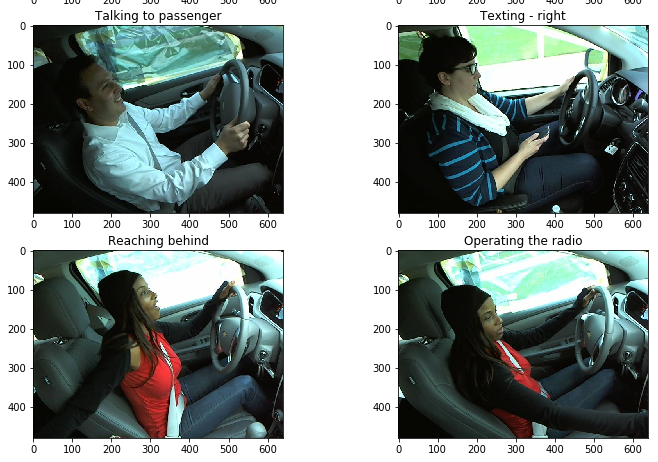

The initial Dataset is composed of a thousand of images labelized as above. The goal of this notebook is to show how to classify them using computer vision techniques

## Some check about libraries

In [2]:
import zipfile
import random
import Augmentor

def unzip_file(zip_path):
    # Get the base name of the zip file (excluding the extension)
    base_name = os.path.splitext(os.path.basename(zip_path))[0]

    # Create a folder with the same name as the zip file
    output_folder = os.path.join(os.path.dirname(zip_path), base_name)
    os.makedirs(output_folder, exist_ok=True)

    # Extract the contents of the zip file to the folder
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)
    return output_folder

def augment_images_in_folder(input_folder, output_folder, num_of_augment_img):
    # Create an Augmentor pipeline for the current image
    pipeline = Augmentor.Pipeline(input_folder, output_directory=output_folder)

    # Add augmentations to the pipeline
    pipeline.flip_left_right(probability=0.8)
    pipeline.shear(probability=0.5, max_shear_left=15, max_shear_right=15)  
    pipeline.rotate(probability=0.5, max_left_rotation=20, max_right_rotation=20)
    
    pipeline.random_brightness(probability=0.2, min_factor=0.5, max_factor=1.5)
    pipeline.random_contrast(probability=0.2, min_factor=0.5, max_factor=1.5)
    pipeline.random_color(probability=0.2, min_factor=0.5, max_factor=1.5)
    
    pipeline.skew(probability=0.5)
    pipeline.histogram_equalisation(probability=0.5)

    pipeline.sample(num_of_augment_img)
    pipeline.augmentor_images.clear()

def unzip_and_augment(zipped_file_path, num_of_augment_img):
    if not os.path.isfile(zipped_file_path):
        file_path = zipped_file_path
    else:
        file_path = unzip_file(zipped_file_path)

    train_folder_path = os.path.join(file_path, "train")
    for subfolder_name in os.listdir(train_folder_path):
        subfolder_path = os.path.join(train_folder_path, subfolder_name)
        # Check if the current item in the directory is a directory itself
        if os.path.isdir(subfolder_path):
            # Create an output path for the augmented images
            output_path = os.path.join('../', subfolder_name)

            # Call the function to augment images in the current subfolder
            augment_images_in_folder(subfolder_path, output_path, num_of_augment_img)
            
file_path = os.path.join('imgs')

num_of_augment_img = 250

unzip_and_augment(file_path, num_of_augment_img)

Initialised with 2489 image(s) found.
Output directory set to imgs\train\c0\../c0.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238D1A700>: 100%|██████████| 250/250 [00:01<00:00, 180.45 Samples/s]                  


Initialised with 2267 image(s) found.
Output directory set to imgs\train\c1\../c1.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238D3B370>: 100%|██████████| 250/250 [00:01<00:00, 166.36 Samples/s]


Initialised with 2317 image(s) found.
Output directory set to imgs\train\c2\../c2.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x2723876A040>: 100%|██████████| 250/250 [00:01<00:00, 170.23 Samples/s]                 


Initialised with 2346 image(s) found.
Output directory set to imgs\train\c3\../c3.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238790E80>: 100%|██████████| 250/250 [00:01<00:00, 169.88 Samples/s]                 


Initialised with 2326 image(s) found.
Output directory set to imgs\train\c4\../c4.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238D2FD90>: 100%|██████████| 250/250 [00:01<00:00, 184.04 Samples/s]                 


Initialised with 2312 image(s) found.
Output directory set to imgs\train\c5\../c5.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x272387ADD90>: 100%|██████████| 250/250 [00:01<00:00, 185.94 Samples/s]


Initialised with 2325 image(s) found.
Output directory set to imgs\train\c6\../c6.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238795A60>: 100%|██████████| 250/250 [00:01<00:00, 183.23 Samples/s]                  


Initialised with 2002 image(s) found.
Output directory set to imgs\train\c7\../c7.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x272385E24F0>: 100%|██████████| 250/250 [00:01<00:00, 178.11 Samples/s]


Initialised with 1911 image(s) found.
Output directory set to imgs\train\c8\../c8.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x27238CE6BB0>: 100%|██████████| 250/250 [00:01<00:00, 179.02 Samples/s]                 


Initialised with 2129 image(s) found.
Output directory set to imgs\train\c9\../c9.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x2723874E130>: 100%|██████████| 250/250 [00:01<00:00, 176.16 Samples/s]


## Part 1 : Loading Dataset  <a class="anchor" id="chapter1"></a>

In [3]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [4]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


### Some functions for loading and normalization

The 10 classes to classify are :
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [5]:
NUMBER_CLASSES = 10 # 10 classes
img_rows = 64 # dimension of images
img_cols = 64
batch_size = 40

In [6]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        print("classed values is",classed)
        path_pattern = os.path.join('imgs', 'train', 'c' + str(classed), '*.jpg')
        #print("path pattern is",path_pattern)
        files = glob(path_pattern)
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    #path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    path = os.path.join('imgs', 'test', '*.jpg')

    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [7]:
color_type = 1 # grey
nb_test_samples = 500

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
classed values is 0



 10%|█         | 1/10 [00:46<07:01, 46.85s/it]

Loading directory c1
classed values is 1



 20%|██        | 2/10 [01:31<06:05, 45.66s/it]

Loading directory c2
classed values is 2



 30%|███       | 3/10 [02:15<05:13, 44.74s/it]

Loading directory c3
classed values is 3



 40%|████      | 4/10 [02:59<04:27, 44.54s/it]

Loading directory c4
classed values is 4



 50%|█████     | 5/10 [03:44<03:43, 44.66s/it]

Loading directory c5
classed values is 5



 60%|██████    | 6/10 [04:29<02:58, 44.71s/it]

Loading directory c6
classed values is 6



 70%|███████   | 7/10 [05:13<02:13, 44.63s/it]

Loading directory c7
classed values is 7



 80%|████████  | 8/10 [05:51<01:25, 42.56s/it]

Loading directory c8
classed values is 8



 90%|█████████ | 9/10 [06:31<00:41, 41.61s/it]

Loading directory c9
classed values is 9


  1%|          | 500/79726 [00:06<17:22, 75.98it/s] 


In [8]:
color_type = 3 # color

# loading train images
x_trainRGB, x_testRGB, y_trainRGB, y_testRGB = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_filesRGB, test_targetsRGB = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)


  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
classed values is 0



 10%|█         | 1/10 [00:10<01:37, 10.80s/it]

Loading directory c1
classed values is 1



 20%|██        | 2/10 [00:20<01:23, 10.43s/it]

Loading directory c2
classed values is 2



 30%|███       | 3/10 [00:29<01:06,  9.46s/it]

Loading directory c3
classed values is 3



 40%|████      | 4/10 [00:38<00:55,  9.23s/it]

Loading directory c4
classed values is 4



 50%|█████     | 5/10 [00:47<00:46,  9.20s/it]

Loading directory c5
classed values is 5



 60%|██████    | 6/10 [00:56<00:36,  9.12s/it]

Loading directory c6
classed values is 6



 70%|███████   | 7/10 [01:04<00:26,  8.92s/it]

Loading directory c7
classed values is 7



 80%|████████  | 8/10 [01:12<00:17,  8.50s/it]

Loading directory c8
classed values is 8



 90%|█████████ | 9/10 [01:19<00:07,  7.98s/it]

Loading directory c9
classed values is 9


  1%|          | 500/79726 [00:01<04:07, 320.56it/s]


In [9]:
x_train_gray3 = np.repeat(x_train, 3, axis=-1)
x_test_gray3 = np.repeat(x_test, 3, axis=-1)

train_generator_grayscale = ImageDataGenerator(validation_split = 0.2)
test_generator_grayscale = ImageDataGenerator()
train_generator_color = ImageDataGenerator(validation_split = 0.2)
test_generator_color = ImageDataGenerator()

grayscale3_train = train_generator_grayscale.flow(x_train_gray3, y_train, batch_size=batch_size, subset='training')
grayscale3_val = train_generator_grayscale.flow(x_train_gray3, y_train, batch_size=batch_size, subset='validation')
grayscale3_test = test_generator_grayscale.flow(x_test_gray3, y_test, batch_size=batch_size)

rgb_train = train_generator_color.flow(x_trainRGB, y_trainRGB, batch_size=batch_size, subset='training')
rgb_val = train_generator_color.flow(x_trainRGB, y_trainRGB, batch_size=batch_size, subset='validation')
rgb_test = test_generator_color.flow(x_testRGB, y_testRGB, batch_size=batch_size)

## Part 2 : EDA  <a class="anchor" id="chapter2"></a>

### Data visualisation

Number of images by category

In [10]:
x_train.shape

(19939, 64, 64, 1)

In [11]:
import plotly.express as px
px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

--> It is well distributed

In [12]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

### Images overview

Let's take a look at the various images in the dataset.
* I'll plot an image for each of the 10 classes.

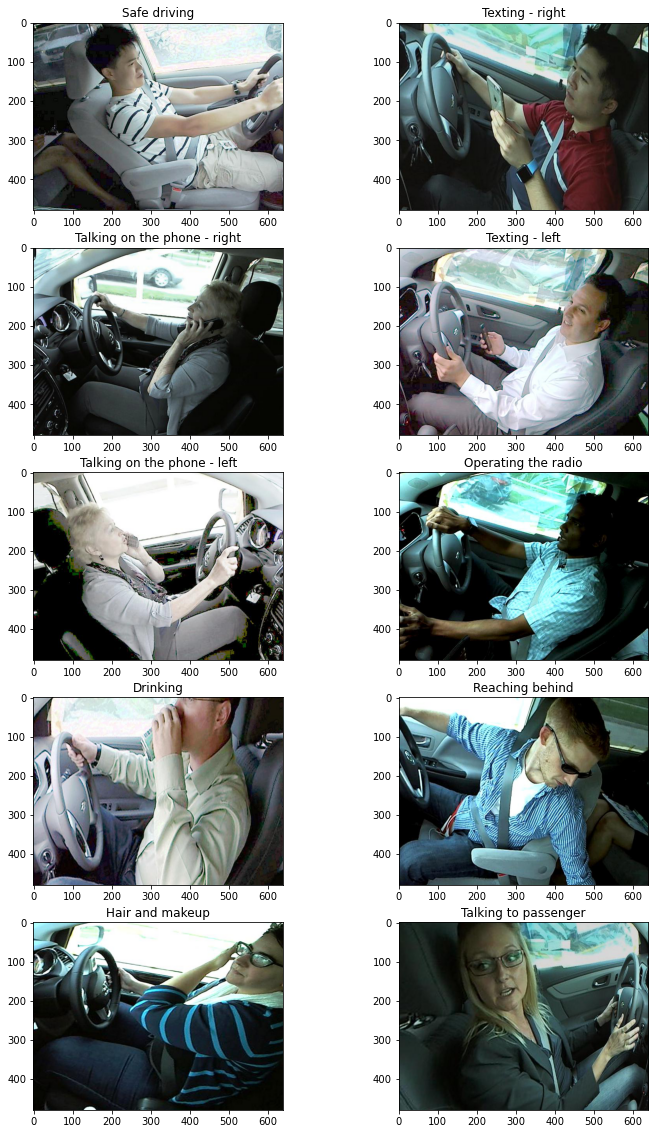

In [13]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

#../input/state-farm-distracted-driver-detection/imgs/train/

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './imgs/train/' 
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [14]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [15]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [16]:
def create_callbacks(model_path):
    checkpointer = ModelCheckpoint(filepath=model_path, 
                                   monitor='val_loss', mode='min',
                                   verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    callbacks = [checkpointer, es]
    return callbacks

In [11]:
from sklearn.metrics import f1_score
import tensorflow_addons as tfa 
f1 = tfa.metrics.F1Score(10, 'micro')

In [18]:
def eval_model(model, model_path, test_generator):
    model.load_weights(model_path)
    score = model.evaluate(test_generator, verbose=1)
    print(score)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    print("Test micro-f1 Score:", score[2])

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def generate_confusion_matrix(model, model_path, test_generator, class_labels):
    # Load the best weights
    model.load_weights(model_path)

    # Predict the classes for the test set
    y_pred = model.predict_generator(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get the true classes indirectly by iterating over the generator
    y_true_classes = []
    num_batches = len(test_generator)
    for i in range(num_batches):
        _, batch_true_classes = test_generator[i]
        y_true_classes.extend(np.argmax(batch_true_classes, axis=1))

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Get class labels
NUMBER_CLASSES = 10
class_labels = [f'c{i}' for i in range(NUMBER_CLASSES)]


## Part 3 : CNN Models  <a class="anchor" id="chapter3"></a>

**Custom model**

Architecture :
- 3 Convolutionnal layers (with Relu, Maxpooling and dropout)
- A flatten layer
- 2 Dense layers with Relu and Dropouts
- 1 Dense layer with softmax for the classification

In [20]:
# Base learning rate
base_lr = 0.001
# number of epochs
nb_epoch = 10

In [21]:
def create_custom_conv_net(img_rows,img_cols,color_type):
    model = Sequential()
    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model


Epoch 1/10


399/399 [==============================] - ETA: 0s - loss: 1.9476 - accuracy: 0.7015 - f1_score: 0.7015
Epoch 1: val_loss improved from inf to 0.44923, saving model to ./saved_models\customcnn_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


399/399 [==============================] - 9s 22ms/step - loss: 1.9476 - accuracy: 0.7015 - f1_score: 0.7015 - val_loss: 0.4492 - val_accuracy: 0.8573 - val_f1_score: 0.8573
Epoch 2/10
398/399 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8900 - f1_score: 0.8900
Epoch 2: val_loss improved from 0.44923 to 0.42171, saving model to ./saved_models\customcnn_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_grayscale\assets


399/399 [==============================] - 8s 21ms/step - loss: 0.3337 - accuracy: 0.8902 - f1_score: 0.8902 - val_loss: 0.4217 - val_accuracy: 0.8701 - val_f1_score: 0.8701
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9183 - f1_score: 0.9183
Epoch 3: val_loss did not improve from 0.42171
399/399 [==============================] - 8s 20ms/step - loss: 0.2447 - accuracy: 0.9183 - f1_score: 0.9183 - val_loss: 0.4317 - val_accuracy: 0.8784 - val_f1_score: 0.8784
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9317 - f1_score: 0.9317
Epoch 4: val_loss did not improve from 0.42171
399/399 [==============================] - 8s 21ms/step - loss: 0.2015 - accuracy: 0.9317 - f1_score: 0.9317 - val_loss: 0.4478 - val_accuracy: 0.8799 - val_f1_score: 0.8799
Epoch 5/10
397/399 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9441 - f1_score: 0.9441
Epoch 5: val_loss did not improve from 

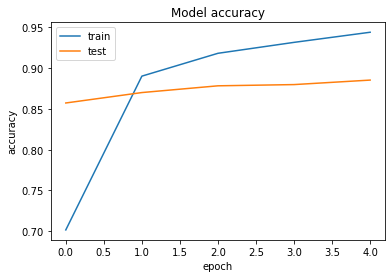

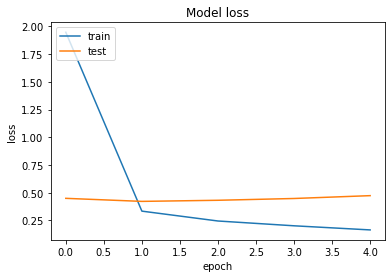

125/125 [==============================] - 1s 7ms/step - loss: 0.4168 - accuracy: 0.8746 - f1_score: 0.8746
[0.41681087017059326, 0.8746238946914673, 0.8746238946914673]
Test Loss: 0.41681087017059326
Test Accuracy: 0.8746238946914673
Test micro-f1 Score: 0.8746238946914673


In [22]:
model = create_custom_conv_net(img_rows,img_cols,1)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy', metrics=['accuracy', f1])
# Create model checkpoint and earlystopper
model_path = './saved_models/customcnn_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale_cnn = model.fit(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale_cnn)
eval_model(model, model_path, grayscale3_test)

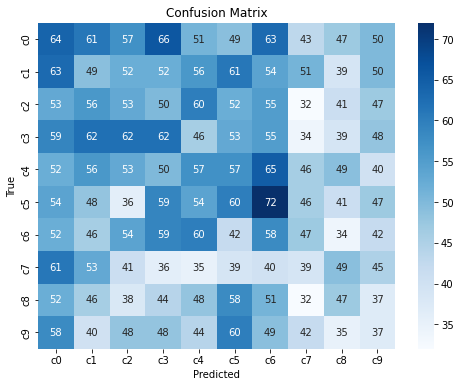

In [23]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
398/399 [============================>.] - ETA: 0s - loss: 1.7082 - accuracy: 0.6951 - f1_score: 0.7379
Epoch 1: val_loss improved from inf to 0.38790, saving model to ./saved_models\customcnn_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


399/399 [==============================] - 10s 23ms/step - loss: 1.7044 - accuracy: 0.6957 - f1_score: 0.7383 - val_loss: 0.3879 - val_accuracy: 0.8774 - val_f1_score: 0.8774
Epoch 2/10
398/399 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8954 - f1_score: 0.8954
Epoch 2: val_loss improved from 0.38790 to 0.33741, saving model to ./saved_models\customcnn_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\customcnn_best_rgb\assets


399/399 [==============================] - 9s 23ms/step - loss: 0.3121 - accuracy: 0.8954 - f1_score: 0.8954 - val_loss: 0.3374 - val_accuracy: 0.8962 - val_f1_score: 0.8962
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9193 - f1_score: 0.9193
Epoch 3: val_loss did not improve from 0.33741
399/399 [==============================] - 9s 21ms/step - loss: 0.2336 - accuracy: 0.9193 - f1_score: 0.9193 - val_loss: 0.3962 - val_accuracy: 0.8947 - val_f1_score: 0.8947
Epoch 4/10
397/399 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9318 - f1_score: 0.9318
Epoch 4: val_loss did not improve from 0.33741
399/399 [==============================] - 9s 21ms/step - loss: 0.1970 - accuracy: 0.9319 - f1_score: 0.9319 - val_loss: 0.3683 - val_accuracy: 0.8929 - val_f1_score: 0.8929
Epoch 5/10
397/399 [============================>.] - ETA: 0s - loss: 0.1666 - accuracy: 0.9437 - f1_score: 0.9437
Epoch 5: val_loss did not improve from 

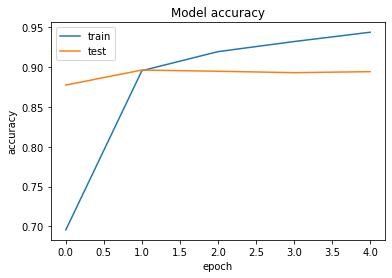

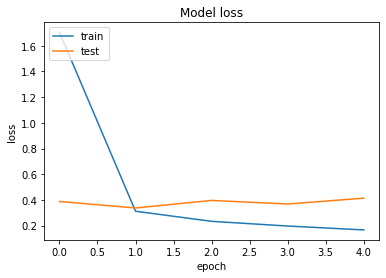

125/125 [==============================] - 1s 7ms/step - loss: 0.3269 - accuracy: 0.8959 - f1_score: 0.8959
[0.3268633782863617, 0.8958876729011536, 0.8958876729011536]
Test Loss: 0.3268633782863617
Test Accuracy: 0.8958876729011536
Test micro-f1 Score: 0.8958876729011536


In [24]:
model = create_custom_conv_net(img_rows,img_cols,3)
categorical_accuracy = keras.metrics.categorical_accuracy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/customcnn_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_cnn = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_cnn)
eval_model(model, model_path, rgb_test)

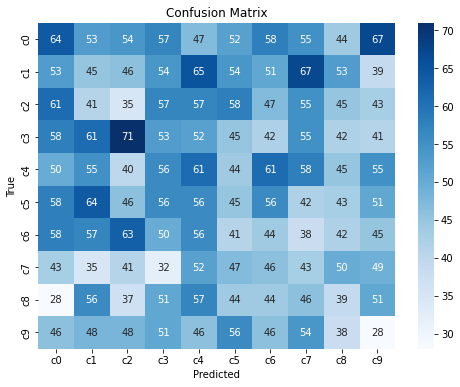

In [25]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**DenseNet**

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121

def DenseNet_Model(img_rows, img_cols, color_type):
    # Load the DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, color_type))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create your model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(NUMBER_CLASSES, activation='softmax'))
    
    return model

config = tf.compat.v1.ConfigProto()
config.allow_soft_placement = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.7455 - accuracy: 0.4208 - f1_score: 0.5339
Epoch 1: val_loss improved from inf to 1.23366, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 69s 163ms/step - loss: 1.7455 - accuracy: 0.4208 - f1_score: 0.5339 - val_loss: 1.2337 - val_accuracy: 0.5942 - val_f1_score: 0.5942
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.5962 - f1_score: 0.5962
Epoch 2: val_loss improved from 1.23366 to 1.01800, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 65s 162ms/step - loss: 1.1968 - accuracy: 0.5962 - f1_score: 0.5962 - val_loss: 1.0180 - val_accuracy: 0.6629 - val_f1_score: 0.6629
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.6550 - f1_score: 0.6550
Epoch 3: val_loss improved from 1.01800 to 0.95768, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 71s 179ms/step - loss: 1.0352 - accuracy: 0.6550 - f1_score: 0.6550 - val_loss: 0.9577 - val_accuracy: 0.6945 - val_f1_score: 0.6945
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.9578 - accuracy: 0.6778 - f1_score: 0.6778
Epoch 4: val_loss improved from 0.95768 to 0.82181, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 74s 184ms/step - loss: 0.9578 - accuracy: 0.6778 - f1_score: 0.6778 - val_loss: 0.8218 - val_accuracy: 0.7527 - val_f1_score: 0.7527
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.6934 - f1_score: 0.6934
Epoch 5: val_loss did not improve from 0.82181
399/399 [==============================] - 52s 130ms/step - loss: 0.9155 - accuracy: 0.6934 - f1_score: 0.6934 - val_loss: 1.0173 - val_accuracy: 0.6556 - val_f1_score: 0.6556
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.7127 - f1_score: 0.7127
Epoch 6: val_loss improved from 0.82181 to 0.81798, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 72s 182ms/step - loss: 0.8767 - accuracy: 0.7127 - f1_score: 0.7127 - val_loss: 0.8180 - val_accuracy: 0.7359 - val_f1_score: 0.7359
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.7111 - f1_score: 0.7111
Epoch 7: val_loss improved from 0.81798 to 0.75949, saving model to ./saved_models\densenet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_grayscale\assets


399/399 [==============================] - 71s 178ms/step - loss: 0.8529 - accuracy: 0.7111 - f1_score: 0.7111 - val_loss: 0.7595 - val_accuracy: 0.7582 - val_f1_score: 0.7582
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.7188 - f1_score: 0.7188
Epoch 8: val_loss did not improve from 0.75949
399/399 [==============================] - 51s 129ms/step - loss: 0.8418 - accuracy: 0.7188 - f1_score: 0.7188 - val_loss: 0.8239 - val_accuracy: 0.7299 - val_f1_score: 0.7299
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.7245 - f1_score: 0.7245
Epoch 9: val_loss did not improve from 0.75949
399/399 [==============================] - 53s 133ms/step - loss: 0.8225 - accuracy: 0.7245 - f1_score: 0.7245 - val_loss: 0.7957 - val_accuracy: 0.7424 - val_f1_score: 0.7424
Epoch 10/10
399/399 [==============================] - ETA: 0s - loss: 0.8160 - accuracy: 0.7296 - f1_score: 0.7296
Epoch 10: val_loss did not impro

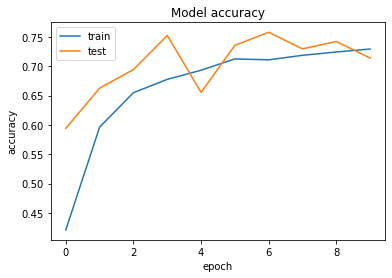

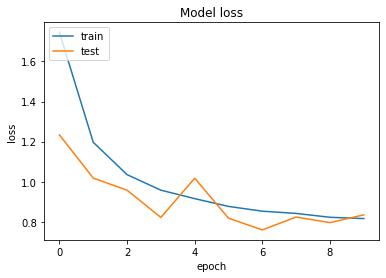

125/125 [==============================] - 13s 105ms/step - loss: 0.7621 - accuracy: 0.7581 - f1_score: 0.7581
[0.7620798349380493, 0.7580742239952087, 0.7580742239952087]
Test Loss: 0.7620798349380493
Test Accuracy: 0.7580742239952087
Test micro-f1 Score: 0.7580742239952087


In [27]:
model = DenseNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/densenet_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_dense = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale3_dense)
eval_model(model, model_path, grayscale3_test)

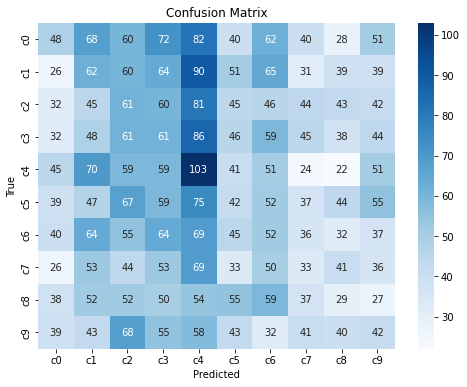

In [28]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.7495 - accuracy: 0.4194 - f1_score: 0.5000
Epoch 1: val_loss improved from inf to 1.12980, saving model to ./saved_models\densenet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


399/399 [==============================] - 75s 180ms/step - loss: 1.7495 - accuracy: 0.4194 - f1_score: 0.5000 - val_loss: 1.1298 - val_accuracy: 0.6255 - val_f1_score: 0.6255
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.6121 - f1_score: 0.6121
Epoch 2: val_loss improved from 1.12980 to 1.04811, saving model to ./saved_models\densenet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


399/399 [==============================] - 70s 176ms/step - loss: 1.1470 - accuracy: 0.6121 - f1_score: 0.6121 - val_loss: 1.0481 - val_accuracy: 0.6627 - val_f1_score: 0.6627
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.6768 - f1_score: 0.6768
Epoch 3: val_loss improved from 1.04811 to 0.80762, saving model to ./saved_models\densenet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


399/399 [==============================] - 77s 194ms/step - loss: 0.9845 - accuracy: 0.6768 - f1_score: 0.6768 - val_loss: 0.8076 - val_accuracy: 0.7404 - val_f1_score: 0.7404
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.9081 - accuracy: 0.6997 - f1_score: 0.6997
Epoch 4: val_loss did not improve from 0.80762
399/399 [==============================] - 59s 147ms/step - loss: 0.9081 - accuracy: 0.6997 - f1_score: 0.6997 - val_loss: 0.8470 - val_accuracy: 0.7346 - val_f1_score: 0.7346
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.7125 - f1_score: 0.7125
Epoch 5: val_loss did not improve from 0.80762
399/399 [==============================] - 61s 153ms/step - loss: 0.8718 - accuracy: 0.7125 - f1_score: 0.7125 - val_loss: 0.8371 - val_accuracy: 0.7407 - val_f1_score: 0.7407
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.7240 - f1_score: 0.7240
Epoch 6: val_loss improved from 0

INFO:tensorflow:Assets written to: ./saved_models\densenet_best_rgb\assets


399/399 [==============================] - 77s 194ms/step - loss: 0.8327 - accuracy: 0.7240 - f1_score: 0.7240 - val_loss: 0.7976 - val_accuracy: 0.7605 - val_f1_score: 0.7605
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.8170 - accuracy: 0.7289 - f1_score: 0.7289
Epoch 7: val_loss did not improve from 0.79762
399/399 [==============================] - 56s 140ms/step - loss: 0.8170 - accuracy: 0.7289 - f1_score: 0.7289 - val_loss: 0.8644 - val_accuracy: 0.7281 - val_f1_score: 0.7281
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.7968 - accuracy: 0.7354 - f1_score: 0.7354
Epoch 8: val_loss did not improve from 0.79762
399/399 [==============================] - 57s 143ms/step - loss: 0.7968 - accuracy: 0.7354 - f1_score: 0.7354 - val_loss: 0.8590 - val_accuracy: 0.7384 - val_f1_score: 0.7384
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.7387 - f1_score: 0.7387
Epoch 9: val_loss did not improve

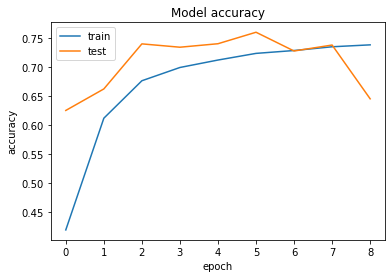

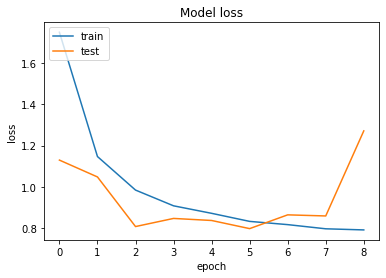

125/125 [==============================] - 13s 107ms/step - loss: 0.7868 - accuracy: 0.7617 - f1_score: 0.7617
[0.786801278591156, 0.7616850733757019, 0.7616850733757019]
Test Loss: 0.786801278591156
Test Accuracy: 0.7616850733757019
Test micro-f1 Score: 0.7616850733757019


In [29]:
model = DenseNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/densenet_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_dense = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_dense)
eval_model(model, model_path, rgb_test)

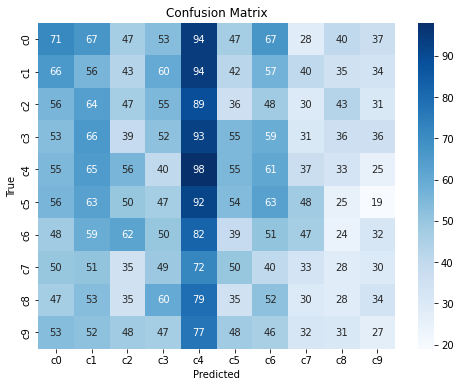

In [30]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**EfficientNet**

In [31]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input

def EfficientNet_Model(img_rows, img_cols, color_type):
    inputs = Input(shape=(img_rows, img_cols, color_type))
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Change the output layer to match the number of classes
    output = Dense(units=NUMBER_CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.7733 - accuracy: 0.4072 - f1_score: 0.4916
Epoch 1: val_loss improved from inf to 1.08121, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 94s 222ms/step - loss: 1.7733 - accuracy: 0.4072 - f1_score: 0.4916 - val_loss: 1.0812 - val_accuracy: 0.6188 - val_f1_score: 0.6188
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.2107 - accuracy: 0.5801 - f1_score: 0.5801
Epoch 2: val_loss improved from 1.08121 to 0.91581, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 89s 224ms/step - loss: 1.2107 - accuracy: 0.5801 - f1_score: 0.5801 - val_loss: 0.9158 - val_accuracy: 0.6772 - val_f1_score: 0.6772
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.6429 - f1_score: 0.6429
Epoch 3: val_loss improved from 0.91581 to 0.66005, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 87s 218ms/step - loss: 1.0396 - accuracy: 0.6429 - f1_score: 0.6429 - val_loss: 0.6601 - val_accuracy: 0.7853 - val_f1_score: 0.7853
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.9426 - accuracy: 0.6785 - f1_score: 0.6785
Epoch 4: val_loss improved from 0.66005 to 0.64497, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 87s 219ms/step - loss: 0.9426 - accuracy: 0.6785 - f1_score: 0.6785 - val_loss: 0.6450 - val_accuracy: 0.7828 - val_f1_score: 0.7828
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.7074 - f1_score: 0.7074
Epoch 5: val_loss improved from 0.64497 to 0.61781, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 87s 218ms/step - loss: 0.8695 - accuracy: 0.7074 - f1_score: 0.7074 - val_loss: 0.6178 - val_accuracy: 0.7931 - val_f1_score: 0.7931
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.7226 - f1_score: 0.7226
Epoch 6: val_loss improved from 0.61781 to 0.58790, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 84s 211ms/step - loss: 0.8326 - accuracy: 0.7226 - f1_score: 0.7226 - val_loss: 0.5879 - val_accuracy: 0.8001 - val_f1_score: 0.8001
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.7350 - f1_score: 0.7350
Epoch 7: val_loss improved from 0.58790 to 0.57294, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 85s 213ms/step - loss: 0.7933 - accuracy: 0.7350 - f1_score: 0.7350 - val_loss: 0.5729 - val_accuracy: 0.8059 - val_f1_score: 0.8059
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.7417 - f1_score: 0.7417
Epoch 8: val_loss did not improve from 0.57294
399/399 [==============================] - 62s 156ms/step - loss: 0.7641 - accuracy: 0.7417 - f1_score: 0.7417 - val_loss: 0.7330 - val_accuracy: 0.7562 - val_f1_score: 0.7562
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.7513 - f1_score: 0.7513
Epoch 9: val_loss improved from 0.57294 to 0.51955, saving model to ./saved_models\efficientnet_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_grayscale\assets


399/399 [==============================] - 83s 208ms/step - loss: 0.7422 - accuracy: 0.7513 - f1_score: 0.7513 - val_loss: 0.5195 - val_accuracy: 0.8279 - val_f1_score: 0.8279
Epoch 10/10
399/399 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.7559 - f1_score: 0.7559
Epoch 10: val_loss did not improve from 0.51955
399/399 [==============================] - 59s 148ms/step - loss: 0.7341 - accuracy: 0.7559 - f1_score: 0.7559 - val_loss: 0.6064 - val_accuracy: 0.7993 - val_f1_score: 0.7993


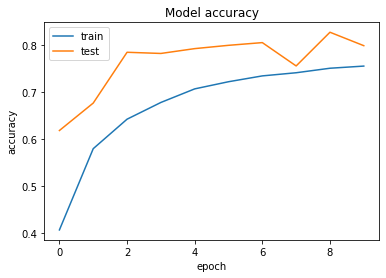

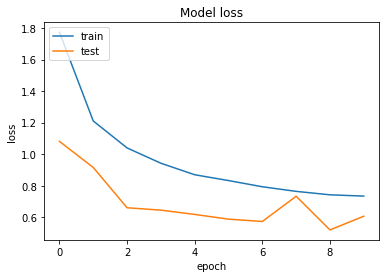

125/125 [==============================] - 14s 112ms/step - loss: 0.5245 - accuracy: 0.8273 - f1_score: 0.8273
[0.5244606137275696, 0.8272818326950073, 0.8272818326950073]
Test Loss: 0.5244606137275696
Test Accuracy: 0.8272818326950073
Test micro-f1 Score: 0.8272818326950073


In [32]:
model = EfficientNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/efficientnet_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_enet = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale3_enet)
eval_model(model, model_path, grayscale3_test)

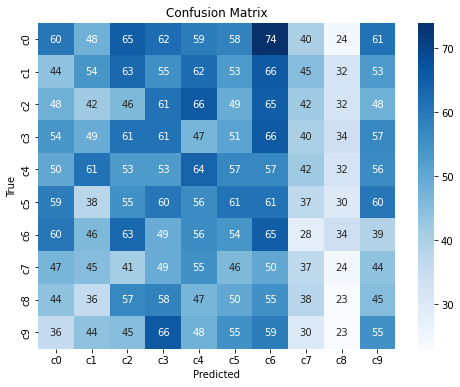

In [33]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.7890 - accuracy: 0.4078 - f1_score: 0.5077
Epoch 1: val_loss improved from inf to 1.08772, saving model to ./saved_models\efficientnet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 87s 205ms/step - loss: 1.7890 - accuracy: 0.4078 - f1_score: 0.5077 - val_loss: 1.0877 - val_accuracy: 0.6436 - val_f1_score: 0.6436
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.1411 - accuracy: 0.6078 - f1_score: 0.6078
Epoch 2: val_loss improved from 1.08772 to 0.72112, saving model to ./saved_models\efficientnet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 81s 204ms/step - loss: 1.1411 - accuracy: 0.6078 - f1_score: 0.6078 - val_loss: 0.7211 - val_accuracy: 0.7552 - val_f1_score: 0.7552
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.6680 - f1_score: 0.6680
Epoch 3: val_loss improved from 0.72112 to 0.66856, saving model to ./saved_models\efficientnet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 79s 197ms/step - loss: 0.9656 - accuracy: 0.6680 - f1_score: 0.6680 - val_loss: 0.6686 - val_accuracy: 0.7680 - val_f1_score: 0.7680
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.7028 - f1_score: 0.7028
Epoch 4: val_loss did not improve from 0.66856
399/399 [==============================] - 58s 144ms/step - loss: 0.8697 - accuracy: 0.7028 - f1_score: 0.7028 - val_loss: 0.6725 - val_accuracy: 0.7770 - val_f1_score: 0.7770
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.8061 - accuracy: 0.7274 - f1_score: 0.7274
Epoch 5: val_loss improved from 0.66856 to 0.51125, saving model to ./saved_models\efficientnet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 78s 196ms/step - loss: 0.8061 - accuracy: 0.7274 - f1_score: 0.7274 - val_loss: 0.5113 - val_accuracy: 0.8400 - val_f1_score: 0.8400
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.7436 - f1_score: 0.7436
Epoch 6: val_loss did not improve from 0.51125
399/399 [==============================] - 56s 141ms/step - loss: 0.7506 - accuracy: 0.7436 - f1_score: 0.7436 - val_loss: 0.5243 - val_accuracy: 0.8109 - val_f1_score: 0.8109
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.7581 - f1_score: 0.7581
Epoch 7: val_loss did not improve from 0.51125
399/399 [==============================] - 132s 332ms/step - loss: 0.7115 - accuracy: 0.7581 - f1_score: 0.7581 - val_loss: 0.5180 - val_accuracy: 0.8347 - val_f1_score: 0.8347
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7723 - f1_score: 0.7723
Epoch 8: val_loss improved from 

INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 177s 444ms/step - loss: 0.6794 - accuracy: 0.7723 - f1_score: 0.7723 - val_loss: 0.4695 - val_accuracy: 0.8518 - val_f1_score: 0.8518
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.7711 - f1_score: 0.7711
Epoch 9: val_loss improved from 0.46949 to 0.41774, saving model to ./saved_models\efficientnet_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\efficientnet_best_rgb\assets


399/399 [==============================] - 77s 193ms/step - loss: 0.6784 - accuracy: 0.7711 - f1_score: 0.7711 - val_loss: 0.4177 - val_accuracy: 0.8656 - val_f1_score: 0.8656
Epoch 10/10
399/399 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.7859 - f1_score: 0.7859
Epoch 10: val_loss did not improve from 0.41774
399/399 [==============================] - 55s 139ms/step - loss: 0.6425 - accuracy: 0.7859 - f1_score: 0.7859 - val_loss: 0.4191 - val_accuracy: 0.8595 - val_f1_score: 0.8595


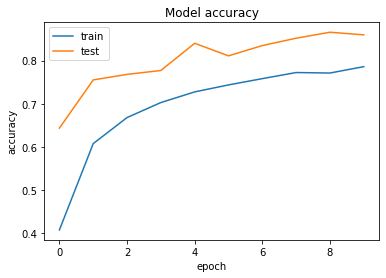

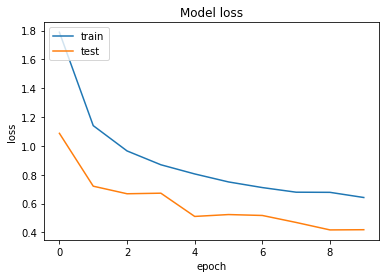

125/125 [==============================] - 13s 107ms/step - loss: 0.4055 - accuracy: 0.8696 - f1_score: 0.8696
[0.40548303723335266, 0.8696088194847107, 0.8696088194847107]
Test Loss: 0.40548303723335266
Test Accuracy: 0.8696088194847107
Test micro-f1 Score: 0.8696088194847107


In [34]:
model = EfficientNet_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/efficientnet_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_enet = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_enet)
eval_model(model, model_path, rgb_test)

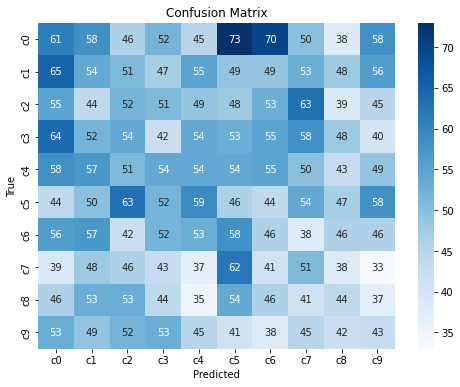

In [35]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**ResNet50**

In [36]:
from keras.applications.resnet import ResNet50

def ResNet50_Model(img_rows, img_cols, color_type=3):
    resnet_model = ResNet50(input_shape=(img_rows, img_cols, color_type), weights="imagenet", include_top=False)
    for layer in resnet_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(resnet_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    
    # Change the output layer to match the number of classes
    predictions = Dense(NUMBER_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=resnet_model.input, outputs=predictions)
    return model

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.3805 - f1_score: 0.4970
Epoch 1: val_loss improved from inf to 1.12306, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 65s 157ms/step - loss: 1.8839 - accuracy: 0.3805 - f1_score: 0.4970 - val_loss: 1.1231 - val_accuracy: 0.6441 - val_f1_score: 0.6441
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.1890 - accuracy: 0.5953 - f1_score: 0.5953
Epoch 2: val_loss improved from 1.12306 to 0.84578, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 65s 162ms/step - loss: 1.1890 - accuracy: 0.5953 - f1_score: 0.5953 - val_loss: 0.8458 - val_accuracy: 0.7176 - val_f1_score: 0.7176
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.6948 - f1_score: 0.6948
Epoch 3: val_loss improved from 0.84578 to 0.65905, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 66s 165ms/step - loss: 0.9253 - accuracy: 0.6948 - f1_score: 0.6948 - val_loss: 0.6591 - val_accuracy: 0.7943 - val_f1_score: 0.7943
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.7296 - f1_score: 0.7296
Epoch 4: val_loss improved from 0.65905 to 0.59625, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 65s 164ms/step - loss: 0.8064 - accuracy: 0.7296 - f1_score: 0.7296 - val_loss: 0.5962 - val_accuracy: 0.8114 - val_f1_score: 0.8114
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.7662 - f1_score: 0.7662
Epoch 5: val_loss improved from 0.59625 to 0.53906, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 66s 166ms/step - loss: 0.6906 - accuracy: 0.7662 - f1_score: 0.7662 - val_loss: 0.5391 - val_accuracy: 0.8287 - val_f1_score: 0.8287
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7903 - f1_score: 0.7903
Epoch 6: val_loss improved from 0.53906 to 0.50840, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 63s 157ms/step - loss: 0.6185 - accuracy: 0.7903 - f1_score: 0.7903 - val_loss: 0.5084 - val_accuracy: 0.8400 - val_f1_score: 0.8400
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.8115 - f1_score: 0.8115
Epoch 7: val_loss improved from 0.50840 to 0.48038, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 62s 156ms/step - loss: 0.5667 - accuracy: 0.8115 - f1_score: 0.8115 - val_loss: 0.4804 - val_accuracy: 0.8493 - val_f1_score: 0.8493
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.8263 - f1_score: 0.8263
Epoch 8: val_loss improved from 0.48038 to 0.46896, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 61s 153ms/step - loss: 0.5284 - accuracy: 0.8263 - f1_score: 0.8263 - val_loss: 0.4690 - val_accuracy: 0.8523 - val_f1_score: 0.8523
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.8324 - f1_score: 0.8324
Epoch 9: val_loss improved from 0.46896 to 0.46256, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


399/399 [==============================] - 62s 156ms/step - loss: 0.4977 - accuracy: 0.8324 - f1_score: 0.8324 - val_loss: 0.4626 - val_accuracy: 0.8540 - val_f1_score: 0.8540
Epoch 10/10
399/399 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8474 - f1_score: 0.8474
Epoch 10: val_loss improved from 0.46256 to 0.45304, saving model to ./saved_models\resnet50_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_grayscale\assets



399/399 [==============================] - 62s 155ms/step - loss: 0.4571 - accuracy: 0.8474 - f1_score: 0.8474 - val_loss: 0.4530 - val_accuracy: 0.8608 - val_f1_score: 0.8608


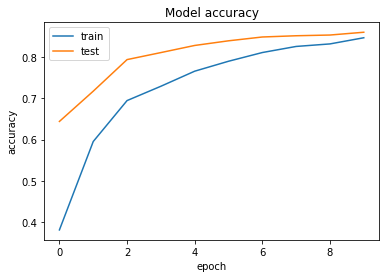

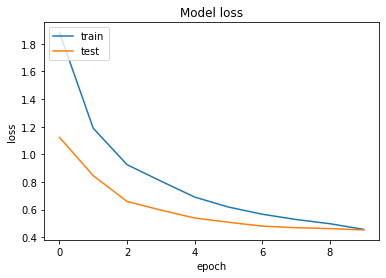

125/125 [==============================] - 12s 96ms/step - loss: 0.4322 - accuracy: 0.8620 - f1_score: 0.8620
[0.43218880891799927, 0.861985981464386, 0.861985981464386]
Test Loss: 0.43218880891799927
Test Accuracy: 0.861985981464386
Test micro-f1 Score: 0.861985981464386


In [37]:
model = ResNet50_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/resnet50_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_resnet = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale3_resnet)
eval_model(model, model_path, grayscale3_test)

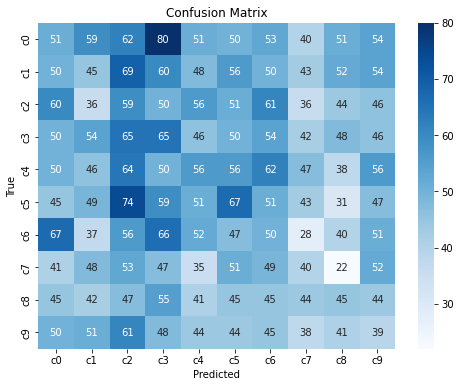

In [38]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.8125 - accuracy: 0.4120 - f1_score: 0.5191
Epoch 1: val_loss improved from inf to 1.03593, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 64s 157ms/step - loss: 1.8125 - accuracy: 0.4120 - f1_score: 0.5191 - val_loss: 1.0359 - val_accuracy: 0.6757 - val_f1_score: 0.6757
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.6407 - f1_score: 0.6407
Epoch 2: val_loss improved from 1.03593 to 0.72140, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 58s 145ms/step - loss: 1.0816 - accuracy: 0.6407 - f1_score: 0.6407 - val_loss: 0.7214 - val_accuracy: 0.7775 - val_f1_score: 0.7775
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.8422 - accuracy: 0.7215 - f1_score: 0.7215
Epoch 3: val_loss improved from 0.72140 to 0.63208, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 62s 155ms/step - loss: 0.8422 - accuracy: 0.7215 - f1_score: 0.7215 - val_loss: 0.6321 - val_accuracy: 0.7981 - val_f1_score: 0.7981
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7709 - f1_score: 0.7709
Epoch 4: val_loss improved from 0.63208 to 0.52113, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 61s 154ms/step - loss: 0.6974 - accuracy: 0.7709 - f1_score: 0.7709 - val_loss: 0.5211 - val_accuracy: 0.8367 - val_f1_score: 0.8367
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7978 - f1_score: 0.7978
Epoch 5: val_loss improved from 0.52113 to 0.49193, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 60s 152ms/step - loss: 0.6049 - accuracy: 0.7978 - f1_score: 0.7978 - val_loss: 0.4919 - val_accuracy: 0.8432 - val_f1_score: 0.8432
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.8156 - f1_score: 0.8156
Epoch 6: val_loss improved from 0.49193 to 0.45570, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 62s 156ms/step - loss: 0.5422 - accuracy: 0.8156 - f1_score: 0.8156 - val_loss: 0.4557 - val_accuracy: 0.8575 - val_f1_score: 0.8575
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.8309 - f1_score: 0.8309
Epoch 7: val_loss improved from 0.45570 to 0.42250, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 62s 155ms/step - loss: 0.4989 - accuracy: 0.8309 - f1_score: 0.8309 - val_loss: 0.4225 - val_accuracy: 0.8693 - val_f1_score: 0.8693
Epoch 8/10
399/399 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8522 - f1_score: 0.8522
Epoch 8: val_loss improved from 0.42250 to 0.40169, saving model to ./saved_models\resnet50_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\resnet50_best_rgb\assets


399/399 [==============================] - 108s 271ms/step - loss: 0.4540 - accuracy: 0.8522 - f1_score: 0.8522 - val_loss: 0.4017 - val_accuracy: 0.8718 - val_f1_score: 0.8718
Epoch 9/10
399/399 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8605 - f1_score: 0.8605
Epoch 9: val_loss did not improve from 0.40169
399/399 [==============================] - 49s 123ms/step - loss: 0.4188 - accuracy: 0.8605 - f1_score: 0.8605 - val_loss: 0.4052 - val_accuracy: 0.8698 - val_f1_score: 0.8698
Epoch 10/10
399/399 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8643 - f1_score: 0.8643
Epoch 10: val_loss did not improve from 0.40169
399/399 [==============================] - 51s 128ms/step - loss: 0.4033 - accuracy: 0.8643 - f1_score: 0.8643 - val_loss: 0.4062 - val_accuracy: 0.8728 - val_f1_score: 0.8728


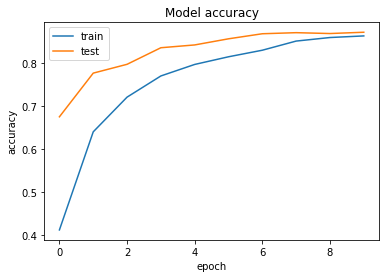

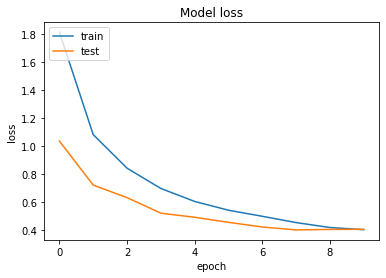

125/125 [==============================] - 13s 104ms/step - loss: 0.3878 - accuracy: 0.8792 - f1_score: 0.8792
[0.3878021836280823, 0.879237711429596, 0.879237711429596]
Test Loss: 0.3878021836280823
Test Accuracy: 0.879237711429596
Test micro-f1 Score: 0.879237711429596


In [39]:
model = ResNet50_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/resnet50_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_resnet = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_resnet)
eval_model(model, model_path, rgb_test)

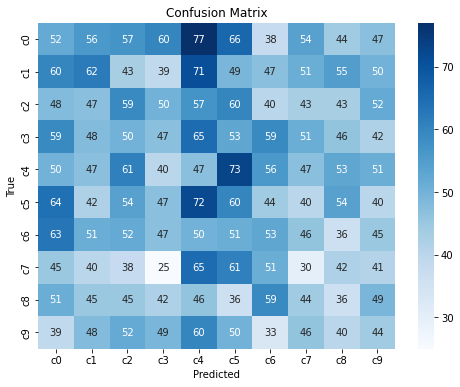

In [40]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**VGG-16**

In [41]:
def VGG16_Model(img_rows, img_cols, color_type=3):
    """
    Architecture and adaptation of the VGG16 for our project
    """
    # Remove fully connected layer and replace
    vgg16_model = VGG16(input_shape=(img_rows, img_cols, color_type), weights="imagenet", include_top=False)
    for layer in vgg16_model.layers:
        layer.trainable = False
    
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUMBER_CLASSES, activation = 'softmax')(x) # add dense layer with 10 neurons and activation softmax
    model = Model(vgg16_model.input,predictions)
    return model

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 1.8237 - accuracy: 0.6913 - f1_score: 0.7361
Epoch 1: val_loss improved from inf to 0.75015, saving model to ./saved_models\vgg16_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


399/399 [==============================] - 109s 271ms/step - loss: 1.8237 - accuracy: 0.6913 - f1_score: 0.7361 - val_loss: 0.7502 - val_accuracy: 0.8109 - val_f1_score: 0.8109
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8823 - f1_score: 0.8823
Epoch 2: val_loss improved from 0.75015 to 0.63525, saving model to ./saved_models\vgg16_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


399/399 [==============================] - 124s 312ms/step - loss: 0.4175 - accuracy: 0.8823 - f1_score: 0.8823 - val_loss: 0.6353 - val_accuracy: 0.8485 - val_f1_score: 0.8485
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9292 - f1_score: 0.9292
Epoch 3: val_loss improved from 0.63525 to 0.63417, saving model to ./saved_models\vgg16_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


399/399 [==============================] - 133s 333ms/step - loss: 0.2257 - accuracy: 0.9292 - f1_score: 0.9292 - val_loss: 0.6342 - val_accuracy: 0.8583 - val_f1_score: 0.8583
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9520 - f1_score: 0.9520
Epoch 4: val_loss improved from 0.63417 to 0.53053, saving model to ./saved_models\vgg16_best_grayscale
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_grayscale\assets


399/399 [==============================] - 101s 254ms/step - loss: 0.1529 - accuracy: 0.9520 - f1_score: 0.9520 - val_loss: 0.5305 - val_accuracy: 0.8796 - val_f1_score: 0.8796
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9623 - f1_score: 0.9623
Epoch 5: val_loss did not improve from 0.53053
399/399 [==============================] - 105s 263ms/step - loss: 0.1254 - accuracy: 0.9623 - f1_score: 0.9623 - val_loss: 0.6633 - val_accuracy: 0.8708 - val_f1_score: 0.8708
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9540 - f1_score: 0.9540
Epoch 6: val_loss did not improve from 0.53053
399/399 [==============================] - 106s 265ms/step - loss: 0.1412 - accuracy: 0.9540 - f1_score: 0.9540 - val_loss: 0.6968 - val_accuracy: 0.8686 - val_f1_score: 0.8686
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9602 - f1_score: 0.9602
Epoch 7: val_loss did not impr

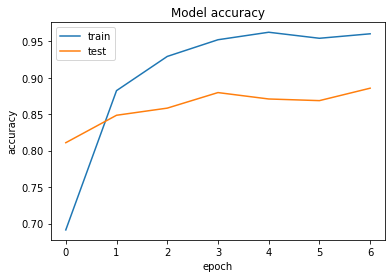

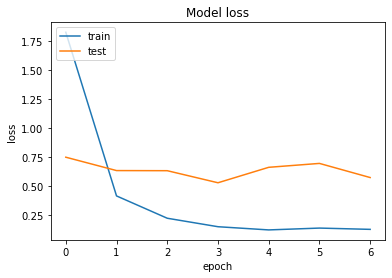

125/125 [==============================] - 26s 206ms/step - loss: 0.5327 - accuracy: 0.8832 - f1_score: 0.8832
[0.5327418446540833, 0.8832497596740723, 0.8832497596740723]
Test Loss: 0.5327418446540833
Test Accuracy: 0.8832497596740723
Test micro-f1 Score: 0.8832497596740723


In [42]:
model = VGG16_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/vgg16_best_grayscale'
callbacks = create_callbacks(model_path)

history_grayscale3_vgg16 = model.fit_generator(grayscale3_train,epochs=nb_epoch,
                                        validation_data=grayscale3_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_grayscale3_vgg16)
eval_model(model, model_path, grayscale3_test)

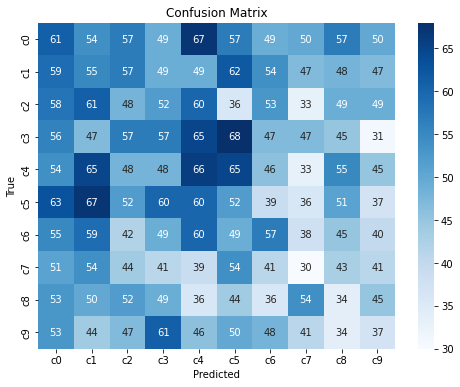

In [43]:
generate_confusion_matrix(model, model_path, grayscale3_test, class_labels)

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 2.0237 - accuracy: 0.7096 - f1_score: 0.7510
Epoch 1: val_loss improved from inf to 0.72403, saving model to ./saved_models\vgg16_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


399/399 [==============================] - 105s 261ms/step - loss: 2.0237 - accuracy: 0.7096 - f1_score: 0.7510 - val_loss: 0.7240 - val_accuracy: 0.8337 - val_f1_score: 0.8337
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8990 - f1_score: 0.8990
Epoch 2: val_loss improved from 0.72403 to 0.63755, saving model to ./saved_models\vgg16_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


399/399 [==============================] - 105s 264ms/step - loss: 0.3556 - accuracy: 0.8990 - f1_score: 0.8990 - val_loss: 0.6375 - val_accuracy: 0.8558 - val_f1_score: 0.8558
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9428 - f1_score: 0.9428
Epoch 3: val_loss improved from 0.63755 to 0.59820, saving model to ./saved_models\vgg16_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


399/399 [==============================] - 106s 266ms/step - loss: 0.1758 - accuracy: 0.9428 - f1_score: 0.9428 - val_loss: 0.5982 - val_accuracy: 0.8768 - val_f1_score: 0.8768
Epoch 4/10
399/399 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9492 - f1_score: 0.9492
Epoch 4: val_loss improved from 0.59820 to 0.59707, saving model to ./saved_models\vgg16_best_rgb
INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


INFO:tensorflow:Assets written to: ./saved_models\vgg16_best_rgb\assets


399/399 [==============================] - 105s 263ms/step - loss: 0.1561 - accuracy: 0.9492 - f1_score: 0.9492 - val_loss: 0.5971 - val_accuracy: 0.8839 - val_f1_score: 0.8839
Epoch 5/10
399/399 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9600 - f1_score: 0.9600
Epoch 5: val_loss did not improve from 0.59707
399/399 [==============================] - 103s 258ms/step - loss: 0.1305 - accuracy: 0.9600 - f1_score: 0.9600 - val_loss: 0.6576 - val_accuracy: 0.8791 - val_f1_score: 0.8791
Epoch 6/10
399/399 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9651 - f1_score: 0.9651
Epoch 6: val_loss did not improve from 0.59707
399/399 [==============================] - 103s 258ms/step - loss: 0.1108 - accuracy: 0.9651 - f1_score: 0.9651 - val_loss: 0.8767 - val_accuracy: 0.8372 - val_f1_score: 0.8372
Epoch 7/10
399/399 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9555 - f1_score: 0.9555
Epoch 7: val_loss did not impr

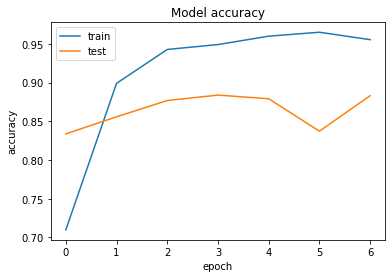

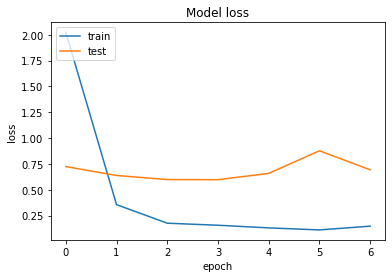

125/125 [==============================] - 25s 201ms/step - loss: 0.5969 - accuracy: 0.8875 - f1_score: 0.8875
[0.5969200134277344, 0.8874623775482178, 0.8874623775482178]
Test Loss: 0.5969200134277344
Test Accuracy: 0.8874623775482178
Test micro-f1 Score: 0.8874623775482178


In [44]:
model = VGG16_Model(img_rows,img_cols,3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',  metrics=['accuracy', f1])

# Create model checkpoint and earlystopper
model_path = './saved_models/vgg16_best_rgb'
callbacks = create_callbacks(model_path)

history_rgb_vgg16 = model.fit_generator(rgb_train,epochs=nb_epoch,
                                        validation_data=rgb_val,
                                        callbacks=callbacks,verbose=1)
plot_train_history(history_rgb_vgg16)
eval_model(model, model_path, rgb_test)

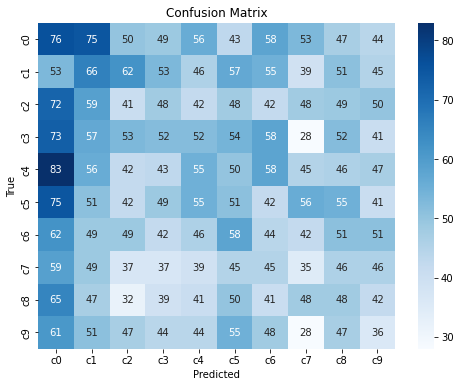

In [45]:
generate_confusion_matrix(model, model_path, rgb_test, class_labels)

**Ensemble**

In [12]:
def Ensemble_Model_Predictions_Test(models_list, test_files):
    individual_predictions = []
    for model in models_list:
        pred = model.predict(test_files, batch_size=batch_size, verbose=1)
        individual_predictions.append(pred)
    ensemble_predictions = tf.stack(individual_predictions, axis=0)
    ensemble_predictions = tf.reduce_mean(ensemble_predictions, axis=0)
    return ensemble_predictions

In [30]:
def Eval_Ensemble(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    f1_metric = tf.keras.metrics.F1Score(average='micro')
    
    loss = cce(y_true, y_pred).numpy()
    acc_metric.update_state(y_true, y_pred)
    acc = acc_metric.result().numpy()
    f1_metric.update_state(y_true, y_pred)
    micro_f1 = f1_metric.result().numpy()
    
    print("Test Loss:", loss)
    print("Test Accuracy:", acc)
    print("Test micro-f1 Score:", micro_f1)

In [33]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_grayscale'
densenet_path = './saved_models/densenet_best_grayscale'
enet_path = './saved_models/efficientnet_best_grayscale'
resnet_path = './saved_models/resnet50_best_grayscale'
vgg_path = './saved_models/vgg16_best_grayscale'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

# Create an instance of the ensemble model
ensemble_model_preds_grayscale = Ensemble_Model_Predictions_Test(models, x_test_gray3)
ensemble_model_preds_grayscale = tf.nn.softmax(ensemble_model_preds_grayscale)
Eval_Ensemble(y_test, ensemble_model_preds_grayscale)

125/125 [==============================] - 26s 211ms/step
Test Loss: 1.6594437
Test Accuracy: 0.9303912
Test micro-f1 Score: 0.9303912


In [32]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_rgb'
densenet_path = './saved_models/densenet_best_rgb'
enet_path = './saved_models/efficientnet_best_rgb'
resnet_path = './saved_models/resnet50_best_rgb'
vgg_path = './saved_models/vgg16_best_rgb'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

ensemble_model_preds = Ensemble_Model_Predictions_Test(models, x_testRGB)
ensemble_model_preds = tf.nn.softmax(ensemble_model_preds)
Eval_Ensemble(y_testRGB, ensemble_model_preds)

125/125 [==============================] - 24s 191ms/step
Test Loss: 1.6489
Test Accuracy: 0.93781346
Test micro-f1 Score: 0.93781346


# Submission

In [10]:
def Ensemble_Model_Predictions(models_list, test_files, test_targets):
    individual_predictions = []
    for model in models_list:
        pred = model.predict(test_files, batch_size=batch_size, verbose=1)
        individual_predictions.append(pred)
        create_submission(pred, test_targets)
    ensemble_predictions = tf.stack(individual_predictions, axis=0)
    ensemble_predictions = tf.reduce_mean(ensemble_predictions, axis=0)
    return ensemble_predictions

In [46]:
def create_submission(predictions, test_id):
    """
    Submission function for participating to the competition
    """
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}".format(str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [47]:
submission_test, submission_targets = read_and_normalize_sampled_test_data(size=79726,img_rows=img_rows, img_cols=img_cols)

100%|██████████| 79726/79726 [14:46<00:00, 89.93it/s] 


In [48]:
submission_test_grayscale, submission_targets_grayscale = read_and_normalize_sampled_test_data(size=79726,img_rows=img_rows, \
                                                                                     img_cols=img_cols, color_type=1)
submission_test_grayscale = np.repeat(submission_test_grayscale, 3, axis=-1)

100%|██████████| 79726/79726 [11:28<00:00, 115.82it/s]


In [60]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_grayscale'
densenet_path = './saved_models/densenet_best_grayscale'
enet_path = './saved_models/efficientnet_best_grayscale'
resnet_path = './saved_models/resnet50_best_grayscale'
vgg_path = './saved_models/vgg16_best_grayscale'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

# Create an instance of the ensemble model
ensemble_model_preds_grayscale = Ensemble_Model_Predictions(models, submission_test_grayscale, submission_targets_grayscale)

1994/1994 [==============================] - 434s 218ms/step


In [63]:
create_submission(ensemble_model_preds_grayscale, submission_targets_grayscale)

'kaggle_submissions\\submission_2023-12-06-22-52.csv'

In [61]:
from tensorflow.keras.models import load_model
# Example usage:
# Paths to the pre-trained model files
cnn_path = './saved_models/customcnn_best_rgb'
densenet_path = './saved_models/densenet_best_rgb'
enet_path = './saved_models/efficientnet_best_rgb'
resnet_path = './saved_models/resnet50_best_rgb'
vgg_path = './saved_models/vgg16_best_rgb'

model_paths = [cnn_path, densenet_path, enet_path, resnet_path, vgg_path]
models = [load_model(path) for path in model_paths]

# Create an instance of the ensemble model
ensemble_model_preds = Ensemble_Model_Predictions(models, submission_test, submission_targets)

1994/1994 [==============================] - 462s 231ms/step


In [62]:
create_submission(ensemble_model_preds, submission_targets)

'kaggle_submissions\\submission_2023-12-06-22-51.csv'